<a href="https://colab.research.google.com/github/wang-zhuoran/Infrared-Temperature-and-Mask-Detection-System/blob/main/Musk_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a Jupeter Notebook environment for creating a **real time Must Detection Model**.

In [5]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
img_array = cv2.imread("/content/drive/MyDrive/Dataset/With_musk/00000_Mask.jpg")

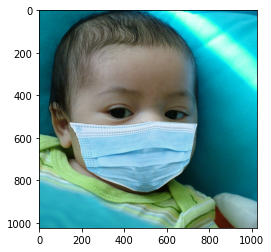

In [ ]:
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

# Pre-process Data

In [6]:
Datadirectory = "/content/drive/MyDrive/Dataset/"

Classes = ["With_musk", "No_musk"]

In [7]:
img_size = 224  # ImageNet => 224 x 224

In [8]:
training_data = []


def create_training_data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_label = Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_label])
            except Exception as e:
                pass

In [9]:
create_training_data()

In [10]:
import random

random.shuffle(training_data)

In [11]:
X = []  # data
y = []  # label

for features, label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1,img_size,img_size,3)

In [12]:
print(X.shape)

(1909, 224, 224, 3)


In [13]:
# normalize the data
X = X / 225.0

Y = np.array(y)

In [14]:
import pickle
pickle_out = open("X.pickle", "wb")
pickle.dump(X,pickle_out,protocol = 4)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y,pickle_out,protocol = 4)
pickle_out.close()

KeyboardInterrupt: ignored

In [ ]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

# Deep learning model for training, Transfer learning

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### pre-trained model: using MobileNet

In [16]:
model = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

# Transfer Learning

In [18]:
base_input = model.layers[0].input

In [19]:
base_output = model.layers[-4].output

In [32]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)

In [33]:
new_model = keras.Model(inputs=base_input, outputs=final_output)


In [34]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

# Setting for binary classification (No_musk, With_musk)

In [35]:
new_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [36]:
new_model.fit(X,Y, epochs=1, validation_split=0.1)

54/54 [==============================] - 309s 6s/step - loss: 0.0649 - accuracy: 0.9773 - val_loss: 0.1060 - val_accuracy: 0.9738


In [37]:
new_model.save('my_first_model.h5')

# Checking the Network for Predictions

In [40]:
frame = cv2.imread("/content/drive/MyDrive/Dataset/No_musk/00000_Mask_Mouth_Chin.jpg")



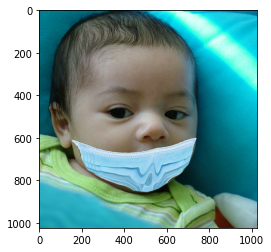

In [41]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [49]:
final_image = cv2.resize(frame,(224,224))
final_image = final_image.reshape(-1,224,224,3) # return the image with shaping that TF wants.

fianl_image = np.expand_dims(final_image,axis=0) # need forth dimension

final_image = final_image/225.0


In [50]:
Predictions = new_model.predict(final_image)

In [67]:
Predictions

array([[1.]], dtype=float32)

In [62]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [63]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [66]:
gray.shape

(1024, 1024)

In [64]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x, y, w, h in faces:
  roi_gray = gray[y:y+h, x:x+h]
  roi_color = frame[y:y+h, x:x+h]
  cv2.rectangle(frame, (x, y), (x + w, y + h), (255,0,0), 2)
  faces = faceCascade.detectMultiScale(roi_gray)
  if len(faces) == 0:
    print("Faces not detected")
  else:
    for (ex,ey,ew,eh) in faces:
      face_roi = roi_color[ey:ey+eh, ex:ex+eh]


Faces not detected


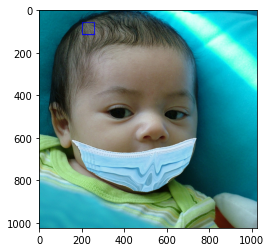

In [65]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))